Ref : https://stats.stackexchange.com/questions/345990/why-does-the-loss-accuracy-fluctuate-during-the-training-keras-lstm

Problems so far
1. Training is unstable
2. Large Parameters (112 x 112), many zero weights

Large network, small dataset: It seems you are training a relatively large network with 200K+ parameters with a very small number of samples, ~100. To put this into perspective, you want to learn 200K parameters or find a good local minimum in a 200K-D space using only 100 samples. Thus, you might end up just wandering around rather than locking down on a good local minima. (The wandering is also due to the second reason below).

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import os
import time
import numpy as np
import pandas as pd

from os import listdir
from io import BytesIO
import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import PIL
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
DATA_DIR = 'data/caps and shoes extended/'
IMAGE_SIZE = (28,28)

In [5]:
def convert_img_to_data(image):
    data = np.asarray(image)
    gs_image = image.convert(mode='L')
    gs_data = np.asarray(gs_image)
    gs_image.thumbnail(IMAGE_SIZE, Image.ANTIALIAS)
    gs_resized = gs_image.resize(IMAGE_SIZE,Image.ANTIALIAS)
    gs_resized_data = np.asarray(gs_resized)
    reshaped_gs_data = gs_resized_data.reshape(IMAGE_SIZE[0]*IMAGE_SIZE[1])
    return reshaped_gs_data

def convert_images_from_dir(dir_path):
    image_data = []
    
    for filename in listdir(dir_path):
        image = Image.open(dir_path +os.sep + filename)
        reshaped_gs_data = convert_img_to_data(image)
        image_data.append(reshaped_gs_data)
    
    return image_data

def load_from_dir(dir_path, labels):
    label_data = []
    image_data = []
    for label in labels:
        data_from_dir = convert_images_from_dir(dir_path + label)
        labels_for_data = [label for i in range(len(data_from_dir))]
        image_data += data_from_dir
        label_data += labels_for_data
    
    print('Found %d images belonging to %d classes' % (len(image_data),  len(labels)))
    return (np.array(image_data),np.array(label_data))

def load_img_data(data_dir):
    train_dir = DATA_DIR + 'train/'
    validation_dir = DATA_DIR + 'val/'
    test_dir = DATA_DIR + 'test/'
    
    if (os.path.isdir(train_dir) and os.path.isdir(validation_dir) and os.path.isdir(test_dir)) :
        labels = [subdirname.name for subdirname in os.scandir(train_dir) if subdirname.is_dir()] 
        
        train_data = load_from_dir(train_dir,labels)
        validation_data = load_from_dir(validation_dir,labels)
        test_data = load_from_dir(test_dir,labels)
        
    return train_data, validation_data, test_data     

def url_to_image(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    return img

def plot_images(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        
        plt.imshow(ims[i].reshape(IMAGE_SIZE[0],IMAGE_SIZE[1]), cmap="gray")

In [6]:
train_data, validation_data, test_data = load_img_data(DATA_DIR)
X_train, y_train = train_data
X_val, y_val = validation_data
X_test, y_test = test_data

Found 2301 images belonging to 2 classes
Found 678 images belonging to 2 classes
Found 327 images belonging to 2 classes


In [7]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [8]:
print('X_train shape : %s' % str(X_train.shape))
print('y_train shape : %s' % str(y_train.shape))
print('X_val shape : %s' % str(X_val.shape))
print('y_val shape : %s' % str(y_val.shape))
print('X_test shape : %s' % str(X_test.shape))
print('y_test shape : %s' % str(y_test.shape))

X_train shape : (2301, 784)
y_train shape : (2301,)
X_val shape : (678, 784)
y_val shape : (678,)
X_test shape : (327, 784)
y_test shape : (327,)


In [9]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

In [10]:
print('y_train shape : %s' % str(y_train.shape))
print('y_val shape : %s' % str(y_val.shape))
print('y_test shape : %s' % str(y_test.shape))

y_train shape : (2301, 2)
y_val shape : (678, 2)
y_test shape : (327, 2)


label for example : [1. 0.]


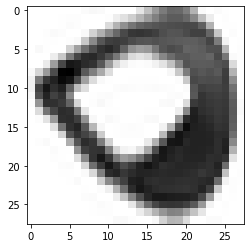

In [11]:
example_ix = 160
image_2d_array = X_train[example_ix].reshape(28,28)
imshow(image_2d_array,cmap="gray", )
print('label for example : %s' % y_train[example_ix])

In [12]:
def define_singlelayer_model_architecture(no_of_neurons=32):
    model = models.Sequential()
    model.add(Dense(no_of_neurons, activation='relu', input_shape=(IMAGE_SIZE[0]*IMAGE_SIZE[1],)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model = define_singlelayer_model_architecture()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 25,186
Trainable params: 25,186
Non-trainable params: 0
_________________________________________________________________


In [14]:
%time history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=1000, batch_size=32, shuffle=True, verbose = 0)

W0810 18:03:31.427835 139648694974272 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 2min 4s, sys: 5.41 s, total: 2min 10s
Wall time: 1min 31s


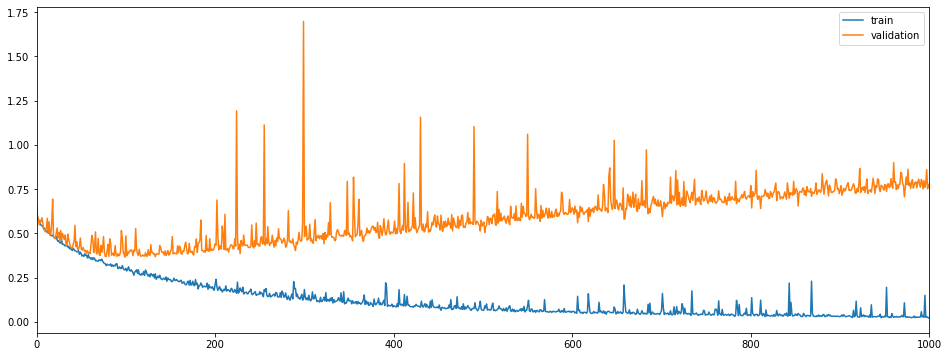

In [15]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, 1000)
plt.show()

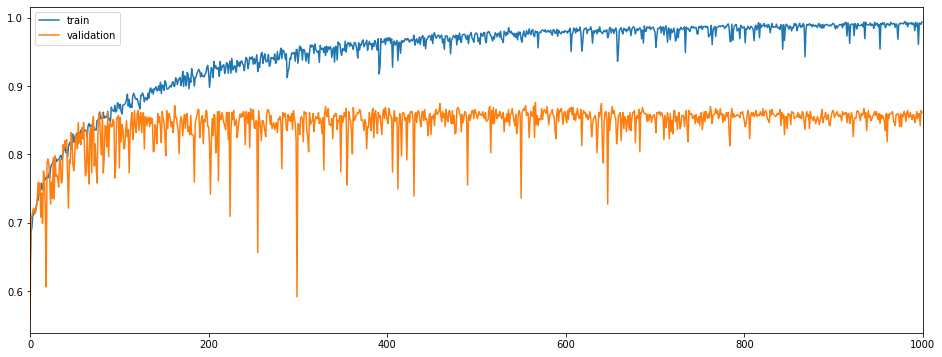

In [16]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, 1000)
plt.show()

In [18]:
%time history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=60, batch_size=32, shuffle=True, verbose = 0)

CPU times: user 7.63 s, sys: 317 ms, total: 7.94 s
Wall time: 5.52 s


In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

327/327 [==============================] - 0s 98us/sample - loss: 0.6674 - accuracy: 0.8624
Test loss: 0.6674 accuracy: 0.8624


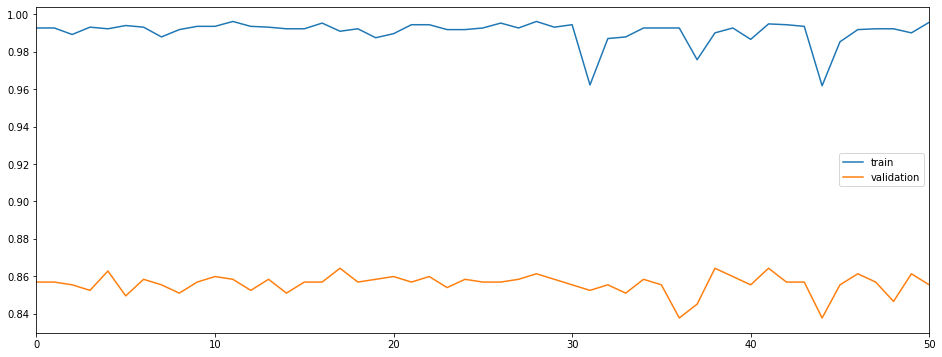

In [20]:
plt.figure(num=None, figsize=(16, 6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlim(0, 50)
plt.show()

In [21]:
ITER = 10
training_time_list = []
test_accuracy_list = []
for iter_count in range(ITER):
    model = define_singlelayer_model_architecture(32)
    start_time = time.time()
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=60, batch_size=32, verbose=0, shuffle=True)
    training_time = time.time() - start_time
    training_time_list.append(training_time)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    test_accuracy_list.append(test_accuracy)

print('Accuracies over 10 runs : %s' % test_accuracy_list)
print('Avg training time : %.3f s' % np.mean(training_time_list))
print('Avg test accuracy : %.4f +- %.2f' % (np.mean(test_accuracy_list), np.std(test_accuracy_list)))
print('Total parameters : %d' % model.count_params())

Accuracies over 10 runs : [0.795107, 0.8440367, 0.75535166, 0.82568806, 0.81957185, 0.8165138, 0.81039757, 0.7217125, 0.80733943, 0.79204893]
Avg training time : 6.075 s
Avg test accuracy : 0.7988 +- 0.03
Total parameters : 25186


In [46]:
predictions = model.predict(X_test)
test_prediction_data = pd.DataFrame(np.hstack([predictions,y_test]).astype("float16"), columns=['predicted_cap','predicted_shoes','actual cap','actual_shoes'])
test_prediction_data[:5]

,predicted_cap,predicted_shoes,actual cap,actual_shoes
0,0.352539,0.647461,1.0,0.0
1,0.385986,0.614258,1.0,0.0
2,0.919434,0.080322,1.0,0.0
3,0.424316,0.575684,1.0,0.0
4,0.914062,0.085999,1.0,0.0


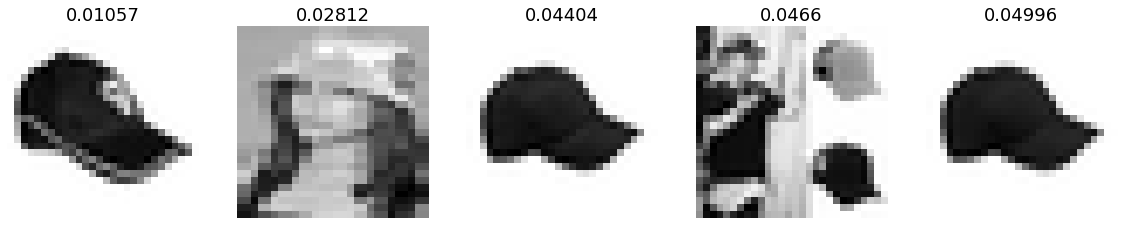

In [49]:
top_wrong_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().index.values[:5]
top_wrong_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().values[:5]
plot_images(X_test[top_wrong_caps_ix],titles=top_wrong_caps_values)

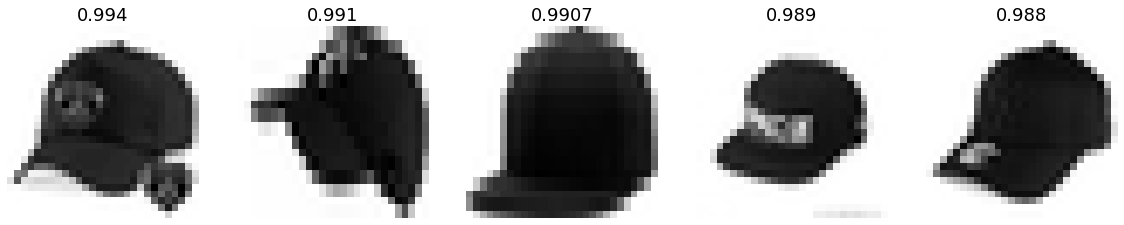

In [50]:
top_correct_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).index.values[:5]
top_correct_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_caps_ix],titles=top_correct_caps_values)

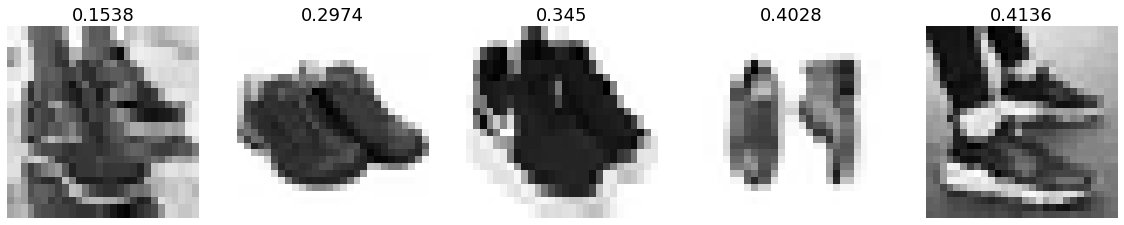

In [51]:
top_wrong_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().index.values[:5]
top_wrong_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().values[:5]
plot_images(X_test[top_wrong_shoes_ix],titles=top_wrong_shoes_values)

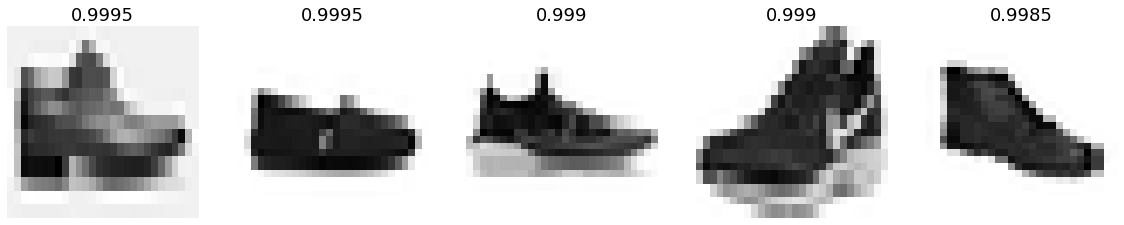

In [52]:
top_correct_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).index.values[:5]
top_correct_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_shoes_ix],titles=top_correct_shoes_values)

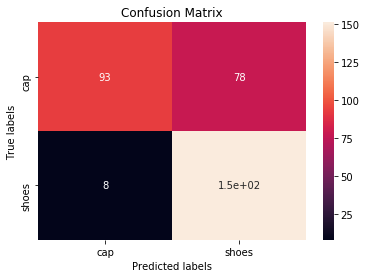

In [53]:
labels = ['cap','shoes']
cm = confusion_matrix(np.argmax(y_test ,axis=1), np.argmax(predictions, axis=1), [0,1])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

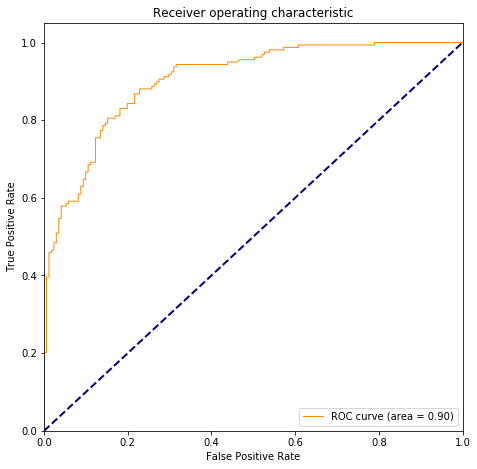

In [54]:
fpr, tpr, thresholds = roc_curve(y_test[:,1], predictions[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7.5, 7.5))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [56]:
layer_0_weights = model.layers[0].get_weights()[0].flatten()
layer_1_weights = model.layers[1].get_weights()[0].flatten()

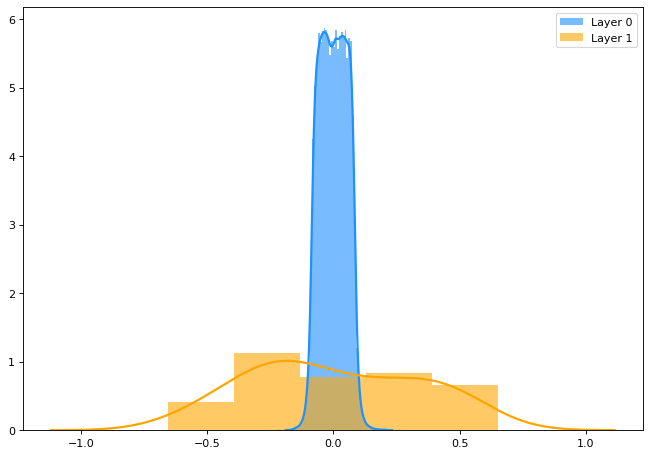

In [57]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(layer_0_weights, color="dodgerblue", label="Layer 0", **kwargs)
sns.distplot(layer_1_weights, color="orange", label="Layer 1", **kwargs)
plt.legend();

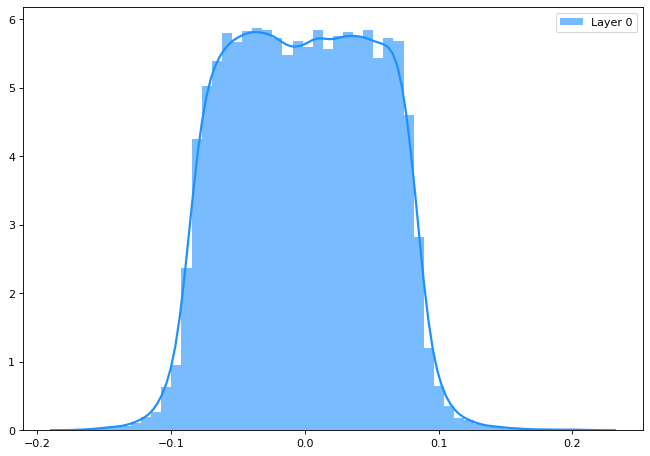

In [59]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(layer_0_weights, color="dodgerblue", label="Layer 0", **kwargs)
#sns.distplot(layer_1_bias, color="orange", label="Layer 1", **kwargs)
plt.legend();

In [60]:
layer_0_bias = model.layers[0].get_weights()[1].flatten()
layer_1_bias = model.layers[1].get_weights()[1].flatten()

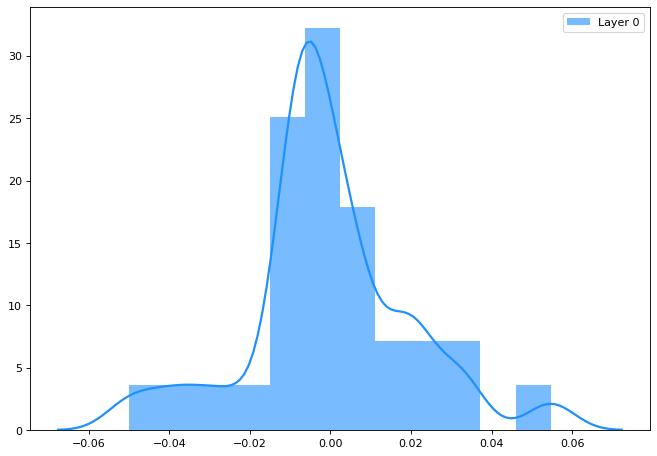

In [61]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(layer_0_bias, color="dodgerblue", label="Layer 0", **kwargs)
#sns.distplot(layer_1_bias, color="orange", label="Layer 1", **kwargs)
plt.legend();

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[0.32820863 0.6717914 ]]


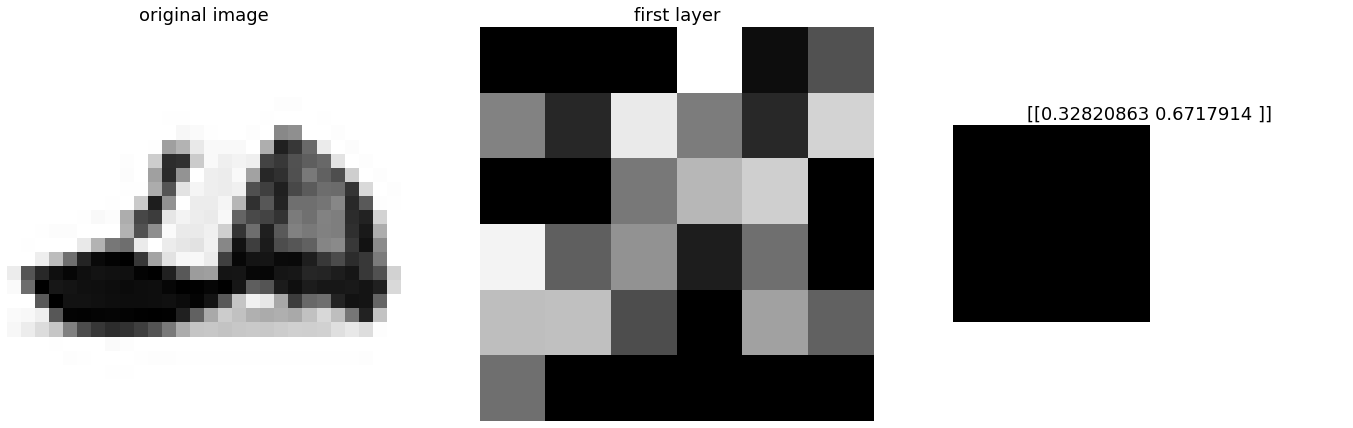

In [64]:
example_ix = 123
image_2d_array = X_train[example_ix].reshape(IMAGE_SIZE[0],IMAGE_SIZE[1])

layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[example_ix].reshape(1,IMAGE_SIZE[0]*IMAGE_SIZE[1]))

first_layer_activation_img = np.pad(activations[0][0], (2, 2), 'constant').reshape(6,6)
second_layer_activation = activations[1]

ims = [image_2d_array,first_layer_activation_img,second_layer_activation]
titles = ['original image', 'first layer', second_layer_activation]

f = plt.figure(figsize=(24,12))
rows = 1
cols = 3

for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('Off')
    sp.set_title(titles[i], fontsize=18)
    plt.imshow(ims[i], cmap="gray")
    
print('~'*120)
print(second_layer_activation)